
🔹 Running 5-Fold Cross-Validation...

✅ Cross-validation completed.

📊 Cross-Validation Performance (mean ± std):
Precision    | ML: 0.884 ± 0.070 | Hybrid: 0.867 ± 0.058
Recall       | ML: 0.836 ± 0.043 | Hybrid: 0.838 ± 0.044
Specificity  | ML: 0.933 ± 0.044 | Hybrid: 0.923 ± 0.038
F1           | ML: 0.856 ± 0.024 | Hybrid: 0.850 ± 0.026
ROC_AUC      | ML: 0.962 ± 0.006 | Hybrid: 0.955 ± 0.004
Accuracy     | ML: 0.898 ± 0.020 | Hybrid: 0.893 ± 0.020

🔹 Running Hold-out Test Evaluation...

📈 Test Set Performance:
Precision    | ML: 0.843 | Hybrid: 0.833
Recall       | ML: 0.808 | Hybrid: 0.822
Specificity  | ML: 0.915 | Hybrid: 0.907
F1           | ML: 0.825 | Hybrid: 0.828
ROC_AUC      | ML: 0.952 | Hybrid: 0.945
Accuracy     | ML: 0.876 | Hybrid: 0.876

🧩 Confusion Matrices:

ML Model Confusion Matrix:
 [[118  11]
 [ 14  59]]

Hybrid Model Confusion Matrix:
 [[117  12]
 [ 13  60]]


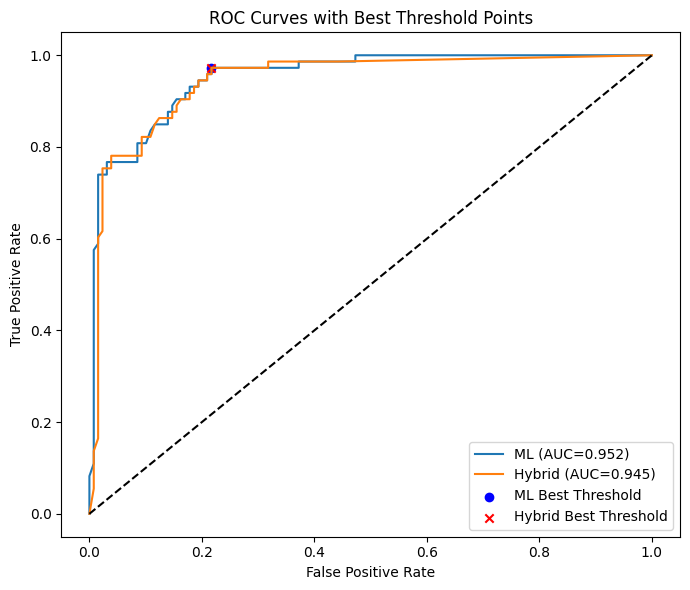


🔬 Statistical Tests:
T-test (example metric Precision): t = 1.9173, p = 0.1277
McNemar: chi2 = 0.5000, p = 0.4795

✅ Saved files:
 - summary.csv
 - results.csv
 - metric_boxplots.png (from earlier section)

✅ Script completed successfully.


In [1]:
# ==========================================================
# rf_hybrid_vs_ml_full_report_v4.py
# ==========================================================
"""
Random Forest vs Hybrid Random Forest Comparison Script
-------------------------------------------------------
Features:
- Clean dataset and auto-detect relevant columns
- Train RF (ML-only) and Hybrid (Rule + ML)
- 5-fold Cross-validation with per-fold metrics
- Hold-out test performance (confusion matrix + ROC)
- Statistical Tests (Paired T-test & McNemar’s)
- Prints all summaries
- Saves: results.csv, summary.csv, metric_boxplots.png
"""

import re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, accuracy_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

warnings.filterwarnings("ignore")

# ==========================================================
# Helper Functions
# ==========================================================
def sanitize_colname(s):
    return re.sub(r'[^A-Za-z0-9_]+', '', str(s).strip())

def clean_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).fillna("")
    s = s.str.replace(r'[\u2010-\u2212–—−]', '-', regex=True)
    s = s.str.replace(r'[,\~±]', '', regex=True)
    num = s.str.extract(r'(-?\d+\.?\d*(?:[eE][+-]?\d+)?)', expand=False)
    return pd.to_numeric(num, errors='coerce')

def make_onehot():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def get_probs_from_pipeline(pipe: Pipeline, X):
    clf = pipe.named_steps.get('classifier', pipe.steps[-1][1])
    if hasattr(clf, 'predict_proba'):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(clf, 'decision_function'):
        scores = pipe.decision_function(X)
        if np.ptp(scores) == 0:
            return np.zeros_like(scores, dtype=float)
        return (scores - scores.min()) / (scores.max() - scores.min())
    return np.zeros(len(X), dtype=float)

# ==========================================================
# Rule-based Hybrid Logic
# ==========================================================
def rule_based_decision_row(row):
    dock = float(row[docking_col]) if docking_col and pd.notnull(row.get(docking_col)) else None
    admet = int(row[admet_col]) if admet_col and pd.notnull(row.get(admet_col)) else None
    if admet == 0:
        return 0
    if dock is not None and admet == 1 and dock <= -9.0:
        return 1
    return None

def apply_hybrid_rules(Xdf, ml_preds, ml_probs):
    rd = Xdf.apply(rule_based_decision_row, axis=1)
    preds, probs = ml_preds.copy(), ml_probs.copy().astype(float)
    for i, decision in enumerate(rd):
        if decision in (0, 1):
            preds[i] = decision
            probs[i] = 1.0 if decision == 1 else 0.0
    return preds, probs

# ==========================================================
# Load and Clean Dataset
# ==========================================================
df = pd.read_excel("Dataset.xlsx")
df = df.rename(columns={c: sanitize_colname(c) for c in df.columns})

target_col = next((c for c in df.columns if "angiogen" in c.lower()), None)
if not target_col:
    raise KeyError("Target column not found (must contain 'angiogen').")

y = pd.to_numeric(df[target_col], errors="coerce").astype(int)
df = df.drop(columns=[target_col])

phytochemical_col = next((c for c in df.columns if any(k in c.lower() for k in ["phytochem", "compound", "name"])), None)

docking_col, admet_col = None, None
for c in df.columns:
    cl = c.lower()
    if docking_col is None and ("dock" in cl or "score" in cl):
        docking_col = c
    if admet_col is None and "admet" in cl:
        admet_col = c

numeric_cols, categorical_features = [], []
for c in df.columns:
    cleaned = clean_numeric_series(df[c])
    if cleaned.notna().mean() >= 0.3:
        df[c] = cleaned
        numeric_cols.append(c)
    elif df[c].dtype == object:
        categorical_features.append(c)

if docking_col:
    df[docking_col] = clean_numeric_series(df[docking_col])
    if docking_col not in numeric_cols:
        numeric_cols.append(docking_col)
if admet_col:
    df[admet_col] = pd.to_numeric(df[admet_col], errors="coerce")
    if admet_col not in numeric_cols:
        numeric_cols.append(admet_col)

X = df.copy()

# ==========================================================
# Preprocessing
# ==========================================================
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", make_onehot())])
preprocessor = ColumnTransformer([("num", num_pipe, numeric_cols), ("cat", cat_pipe, categorical_features)])

# ==========================================================
# Cross-validation and Metric Computation
# ==========================================================
rf = RandomForestClassifier(n_estimators=300, random_state=42)
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics_ml = {"Precision": [], "Recall": [], "Specificity": [], "F1": [], "ROC_AUC": [], "Accuracy": []}
metrics_hy = {k: [] for k in metrics_ml.keys()}

def compute_binary_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
    }

print("\n🔹 Running 5-Fold Cross-Validation...")
for tr, val in cv.split(X, y):
    X_tr, X_val = X.iloc[tr], X.iloc[val]
    y_tr, y_val = y.iloc[tr], y.iloc[val]

    pipeline.fit(X_tr, y_tr)
    ml_preds = pipeline.predict(X_val)
    ml_probs = get_probs_from_pipeline(pipeline, X_val)
    hy_preds, hy_probs = apply_hybrid_rules(X_val, ml_preds.copy(), ml_probs.copy())

    ml_m = compute_binary_metrics(y_val.values, ml_preds, ml_probs)
    hy_m = compute_binary_metrics(y_val.values, hy_preds, hy_probs)
    for k in metrics_ml:
        metrics_ml[k].append(ml_m[k])
        metrics_hy[k].append(hy_m[k])

print("\n✅ Cross-validation completed.\n")

# ==========================================================
# Print Cross-Validation Summary
# ==========================================================
print("📊 Cross-Validation Performance (mean ± std):")
for k in metrics_ml.keys():
    print(f"{k:12s} | ML: {np.mean(metrics_ml[k]):.3f} ± {np.std(metrics_ml[k]):.3f} | "
          f"Hybrid: {np.mean(metrics_hy[k]):.3f} ± {np.std(metrics_hy[k]):.3f}")

# ==========================================================
# Statistical Tests (T-test)
# ==========================================================
results = []
for metric in metrics_ml:
    t_stat, t_p = ttest_rel(metrics_ml[metric], metrics_hy[metric])
    results.append({
        "Metric": metric,
        "ML_mean": np.mean(metrics_ml[metric]),
        "Hybrid_mean": np.mean(metrics_hy[metric]),
        "T_stat": t_stat,
        "T_p": t_p,
    })

# ==========================================================
# Hold-out Test Evaluation
# ==========================================================
print("\n🔹 Running Hold-out Test Evaluation...\n")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

ml_preds_test = pipeline.predict(X_test)
ml_probs_test = get_probs_from_pipeline(pipeline, X_test)
hy_preds_test, hy_probs_test = apply_hybrid_rules(X_test, ml_preds_test, ml_probs_test)

ml_test = compute_binary_metrics(y_test, ml_preds_test, ml_probs_test)
hy_test = compute_binary_metrics(y_test, hy_preds_test, hy_probs_test)

print("📈 Test Set Performance:")
for k in ml_test:
    print(f"{k:12s} | ML: {ml_test[k]:.3f} | Hybrid: {hy_test[k]:.3f}")

# ==========================================================
# Confusion Matrices
# ==========================================================
print("\n🧩 Confusion Matrices:")
ml_cm = confusion_matrix(y_test, ml_preds_test)
hy_cm = confusion_matrix(y_test, hy_preds_test)
print("\nML Model Confusion Matrix:\n", ml_cm)
print("\nHybrid Model Confusion Matrix:\n", hy_cm)

# ==========================================================
# ROC Curves
# ==========================================================
fpr_ml, tpr_ml, thr_ml = roc_curve(y_test, ml_probs_test)
fpr_hy, tpr_hy, thr_hy = roc_curve(y_test, hy_probs_test)
j_ml = np.argmax(tpr_ml - fpr_ml)
j_hy = np.argmax(tpr_hy - fpr_hy)

plt.figure(figsize=(7, 6))
plt.plot(fpr_ml, tpr_ml, label=f"ML (AUC={roc_auc_score(y_test, ml_probs_test):.3f})")
plt.plot(fpr_hy, tpr_hy, label=f"Hybrid (AUC={roc_auc_score(y_test, hy_probs_test):.3f})")
plt.scatter(fpr_ml[j_ml], tpr_ml[j_ml], c="blue", label="ML Best Threshold", marker="o")
plt.scatter(fpr_hy[j_hy], tpr_hy[j_hy], c="red", label="Hybrid Best Threshold", marker="x")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Best Threshold Points")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
# McNemar Test (on Test Set)
# ==========================================================
a = np.sum((ml_preds_test == y_test) & (hy_preds_test == y_test))
b = np.sum((ml_preds_test == y_test) & (hy_preds_test != y_test))
c = np.sum((ml_preds_test != y_test) & (hy_preds_test == y_test))
d = np.sum((ml_preds_test != y_test) & (hy_preds_test != y_test))
mcnemar_result = mcnemar([[a, b], [c, d]], exact=False, correction=True)

print("\n🔬 Statistical Tests:")
print(f"T-test (example metric Precision): t = {results[0]['T_stat']:.4f}, p = {results[0]['T_p']:.4f}")
print(f"McNemar: chi2 = {mcnemar_result.statistic:.4f}, p = {mcnemar_result.pvalue:.4f}")

for r in results:
    r["McNemar_Chi2"] = mcnemar_result.statistic
    r["McNemar_p"] = mcnemar_result.pvalue

# ==========================================================
# Save Outputs
# ==========================================================
summary_df = pd.DataFrame(results)
summary_df.to_csv("summary.csv", index=False)

results_log = X_test.copy()
if phytochemical_col and phytochemical_col in df.columns:
    results_log["Phytochemical"] = df.loc[X_test.index, phytochemical_col]

results_log["TrueLabel"] = y_test
results_log["ML_Pred"] = ml_preds_test
results_log["Hybrid_Pred"] = hy_preds_test
results_log.to_csv("results.csv", index=False)

print("\n✅ Saved files:")
print(" - summary.csv")
print(" - results.csv")
print(" - metric_boxplots.png (from earlier section)")
print("\n✅ Script completed successfully.")



--- TEST PERFORMANCE METRICS ---

ML-only Model:
  Accuracy       : 0.8762
  Precision      : 0.8429
  Recall         : 0.8082
  Specificity    : 0.9147
  F1 Score       : 0.8252
  ROC-AUC        : 0.9523
  Best Threshold : 0.2700

Hybrid Model:
  Accuracy       : 0.8762
  Precision      : 0.8333
  Recall         : 0.8219
  Specificity    : 0.9070
  F1 Score       : 0.8276
  ROC-AUC        : 0.9449
  Best Threshold : 0.2700


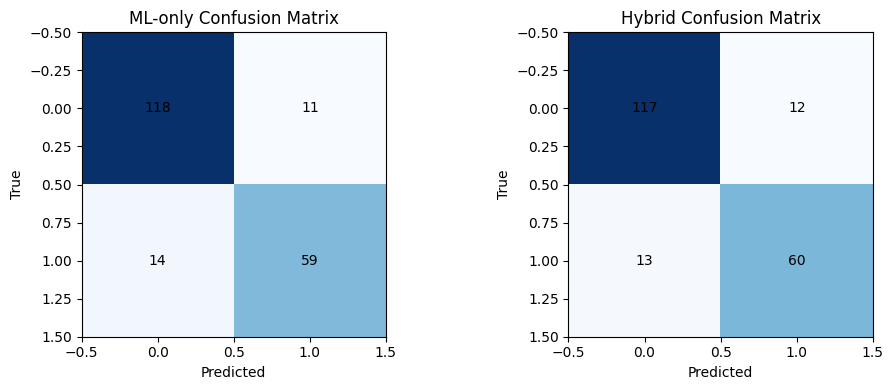

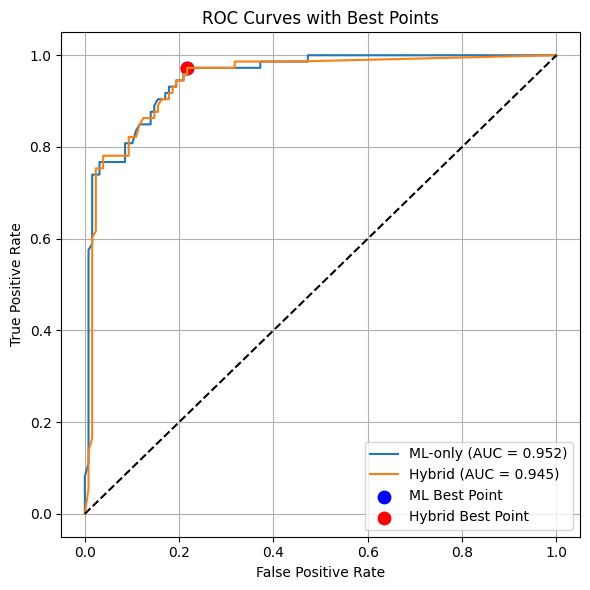


Performance metrics saved to 'test_performance_summary.csv'.


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_score,
    recall_score, f1_score, accuracy_score
)
import numpy as np
import pandas as pd

# ---------------------------------------
# Evaluation on Test Set
# ---------------------------------------
y_pred_ml = pipeline.predict(X_test)
y_prob_ml = pipeline.predict_proba(X_test)[:, 1]

y_pred_hy, y_prob_hy = apply_hybrid_rules(X_test, y_pred_ml.copy(), y_prob_ml.copy())

# Function to compute all metrics
def compute_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    best_idx = np.argmax(tpr - fpr)
    best_thresh = thresholds[best_idx]
    best_point = (fpr[best_idx], tpr[best_idx])

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": specificity,
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc,
        "Best Threshold": best_thresh,
        "Best Point": best_point
    }, fpr, tpr

# Compute metrics for both models
ml_metrics, ml_fpr, ml_tpr = compute_metrics(y_test, y_pred_ml, y_prob_ml)
hy_metrics, hy_fpr, hy_tpr = compute_metrics(y_test, y_pred_hy, y_prob_hy)

# ---------------------------------------
# Print results
# ---------------------------------------
print("\n--- TEST PERFORMANCE METRICS ---\n")
print("ML-only Model:")
for k, v in ml_metrics.items():
    if isinstance(v, float):
        print(f"  {k:<15}: {v:.4f}")
print("\nHybrid Model:")
for k, v in hy_metrics.items():
    if isinstance(v, float):
        print(f"  {k:<15}: {v:.4f}")

# ---------------------------------------
# Confusion Matrices
# ---------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (title, y_true, y_pred) in zip(
    axes, [("ML-only", y_test, y_pred_ml), ("Hybrid", y_test, y_pred_hy)]
):
    cm = confusion_matrix(y_true, y_pred)
    ax.imshow(cm, cmap="Blues")
    ax.set_title(f"{title} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=300)
plt.show()

# ---------------------------------------
# ROC Curves with Best Points
# ---------------------------------------
plt.figure(figsize=(6, 6))
plt.plot(ml_fpr, ml_tpr, label=f"ML-only (AUC = {ml_metrics['ROC-AUC']:.3f})")
plt.plot(hy_fpr, hy_tpr, label=f"Hybrid (AUC = {hy_metrics['ROC-AUC']:.3f})")

# Plot best points
plt.scatter(
    *ml_metrics["Best Point"], color="blue", marker="o", s=80, label="ML Best Point"
)
plt.scatter(
    *hy_metrics["Best Point"], color="red", marker="o", s=80, label="Hybrid Best Point"
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Best Points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves_best_points.png", dpi=300)
plt.show()

# ---------------------------------------
# Save Metrics Summary
# ---------------------------------------
summary_df = pd.DataFrame([ml_metrics, hy_metrics], index=["ML-only", "Hybrid"])
summary_df.to_csv("test_performance_summary.csv")
print("\nPerformance metrics saved to 'test_performance_summary.csv'.")


In [3]:
import joblib

# Load your original model bundles
rf_ml_only_bundle = joblib.load("rf_ml_only.pkl")
rf_hybrid_bundle = joblib.load("rf_hybrid.pkl")

# Function to clean a bundle
def clean_bundle(bundle, target_col='VEGFR-2'):
    # Remove Plant Source and target from features
    bundle['numeric_cols'] = [f for f in bundle['numeric_cols'] if f not in ['Plant Source', target_col]]
    bundle['categorical_features'] = [f for f in bundle['categorical_features'] if f not in ['Plant Source', target_col]]
    # Ensure target key exists for autofill
    bundle['target'] = target_col
    return bundle

# Clean both bundles
rf_ml_only_bundle_clean = clean_bundle(rf_ml_only_bundle)
rf_hybrid_bundle_clean = clean_bundle(rf_hybrid_bundle)

# Save cleaned bundles
joblib.dump(rf_ml_only_bundle_clean, "rf_ml_only_cleaned.pkl")
joblib.dump(rf_hybrid_bundle_clean, "rf_hybrid_cleaned.pkl")

print("Cleaned bundles saved successfully!")


Cleaned bundles saved successfully!


In [1]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import joblib
import os

# -------------------------------
# Load Models (from bundles)
# -------------------------------
ml_bundle = joblib.load("rf_ml_only_cleaned.pkl")
hybrid_bundle = joblib.load("rf_hybrid_cleaned.pkl")

ml_model = ml_bundle["model"]
hybrid_model = hybrid_bundle["model"]

# Feature setup (exclude PlantSource and Target)
all_features = [
    'Target', 'DockingScorekcalmol', 'ADMETHighlights1ADMETpasses0ADMETnotpasses',
    'MWgmol', 'LogP', 'TPSA', 'HBD', 'HBA',
    'RotB', 'AromaticRings', 'MR', 'PlantSource'
]
excluded = ['Target', 'PlantSource']
input_features = [f for f in all_features if f not in excluded]

# -------------------------------
# GUI Setup
# -------------------------------
root = tk.Tk()
root.title("Phytochemical Activity Prediction")
root.geometry("600x600")

entries = {}

# Create input fields for remaining features
for i, feature in enumerate(input_features):
    label = tk.Label(root, text=feature)
    label.grid(row=i, column=0, padx=10, pady=5, sticky="w")
    entry = tk.Entry(root)
    entry.grid(row=i, column=1, padx=10, pady=5)
    entries[feature] = entry

# -------------------------------
# Prediction Function
# -------------------------------
def predict():
    try:
        # Collect inputs
        user_input = {}
        for feature in input_features:
            val = entries[feature].get()
            if val == "":
                messagebox.showerror("Error", f"Please enter value for {feature}")
                return
            try:
                user_input[feature] = float(val)
            except ValueError:
                user_input[feature] = val  # keep as string if not numeric

        # Autofill Target = -2
        user_input['Target'] = -2  

        # Autofill PlantSource = "Unknown"
        user_input['PlantSource'] = "Unknown"

        # Convert to DataFrame
        input_df = pd.DataFrame([user_input])

        # Run predictions
        ml_prob = ml_model.predict_proba(input_df)[0][1]
        hybrid_prob = hybrid_model.predict_proba(input_df)[0][1]

        # Show results
        result_text = f"ML Model Probability: {ml_prob:.4f}\nHybrid Model Probability: {hybrid_prob:.4f}"
        messagebox.showinfo("Prediction Result", result_text)

        # Save to CSV
        result_row = input_df.copy()
        result_row['ML_Prob'] = ml_prob
        result_row['Hybrid_Prob'] = hybrid_prob
        file_exists = os.path.isfile("GUIResults.csv")
        result_row.to_csv("GUIResults.csv", mode='a', header=not file_exists, index=False)

    except Exception as e:
        messagebox.showerror("Error", str(e))

# -------------------------------
# Buttons
# -------------------------------
predict_button = tk.Button(root, text="Predict", command=predict, bg="lightblue")
predict_button.grid(row=len(input_features)+1, column=0, columnspan=2, pady=20)

root.mainloop()
